# Interpretação dos Clusters - Economiza+ MVP

**Objetivo:** Caracterizar e nomear os clusters identificados

## Checklist:
- [ ] Médias por cluster
- [ ] Nomear clusters
- [ ] Tabela comparativa
- [ ] 2-3 boxplots

**Entregável:** `Perfis_Clusters.md`

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Carregar dados
df = pd.read_csv('../data/processed/dataset_clusters_validado.csv')
print(f'Dataset: {df.shape[0]} usuários, {df["cluster"].nunique()} clusters')

Dataset: 500 usuários, 4 clusters


## 2. Médias por Cluster

In [2]:
# Features para análise
FEATURES = ['media_renda', 'media_gasto', 'taxa_poupanca', 'pct_gastos_essenciais', 'std_gasto']

# Médias por cluster
medias = df.groupby('cluster')[FEATURES].mean()

print('MÉDIAS POR CLUSTER')
print('='*80)
medias.round(2)

MÉDIAS POR CLUSTER


,media_renda,media_gasto,taxa_poupanca,pct_gastos_essenciais,std_gasto
cluster,,,,,
0,3692.62,7297.56,-0.89,0.07,3591.81
1,3131.48,3468.84,-0.15,0.05,1411.29
2,3154.59,4900.49,-0.58,0.06,1993.49
3,7194.09,5235.71,0.25,0.04,2227.41


In [3]:
# Adicionar métricas derivadas
medias['saldo_medio'] = medias['media_renda'] - medias['media_gasto']
medias['qtd_usuarios'] = df.groupby('cluster').size()
medias['pct_base'] = (medias['qtd_usuarios'] / len(df) * 100).round(1)

print('\nRESUMO COM SALDO:')
medias[['qtd_usuarios', 'pct_base', 'media_renda', 'media_gasto', 'saldo_medio', 'taxa_poupanca']].round(2)


RESUMO COM SALDO:


,qtd_usuarios,pct_base,media_renda,media_gasto,saldo_medio,taxa_poupanca
cluster,,,,,,
0,59,11.8,3692.62,7297.56,-3604.94,-0.89
1,196,39.2,3131.48,3468.84,-337.36,-0.15
2,167,33.4,3154.59,4900.49,-1745.90,-0.58
3,78,15.6,7194.09,5235.71,1958.38,0.25


## 3. Nomear Clusters

In [4]:
# Classificar clusters baseado na taxa de poupança e renda
renda_media_geral = df['media_renda'].mean()

def nomear_cluster(cluster_id):
    taxa = medias.loc[cluster_id, 'taxa_poupanca']
    renda = medias.loc[cluster_id, 'media_renda']
    
    if taxa > 0.15 and renda > renda_media_geral:
        return 'Poupadores'
    elif taxa > 0 and taxa <= 0.15:
        return 'Equilibrados'
    elif taxa < 0 and taxa >= -0.5:
        return 'Em Alerta'
    else:
        return 'Endividados'

# Criar mapeamento
cluster_names = {c: nomear_cluster(c) for c in medias.index}

print('NOMEAÇÃO DOS CLUSTERS:')
print('='*50)
for cluster_id, nome in cluster_names.items():
    taxa = medias.loc[cluster_id, 'taxa_poupanca'] * 100
    qtd = int(medias.loc[cluster_id, 'qtd_usuarios'])
    print(f'Cluster {cluster_id} -> {nome:15} | {qtd:3} usuários | Taxa: {taxa:+.1f}%')

# Adicionar ao dataframe
df['cluster_nome'] = df['cluster'].map(cluster_names)
medias['nome'] = pd.Series(cluster_names)

NOMEAÇÃO DOS CLUSTERS:
Cluster 0 -> Endividados     |  59 usuários | Taxa: -88.6%
Cluster 1 -> Em Alerta       | 196 usuários | Taxa: -14.8%
Cluster 2 -> Endividados     | 167 usuários | Taxa: -57.7%
Cluster 3 -> Poupadores      |  78 usuários | Taxa: +25.4%


## 4. Tabela Comparativa

In [5]:
# Tabela comparativa final
tabela = medias[['nome', 'qtd_usuarios', 'pct_base', 'media_renda', 'media_gasto', 'saldo_medio', 'taxa_poupanca']].copy()
tabela.columns = ['Nome', 'Usuários', '% Base', 'Renda Média', 'Gasto Médio', 'Saldo', 'Taxa Poupança']
tabela['Taxa Poupança'] = (tabela['Taxa Poupança'] * 100).round(1).astype(str) + '%'
tabela['Renda Média'] = tabela['Renda Média'].apply(lambda x: f'R$ {x:,.0f}')
tabela['Gasto Médio'] = tabela['Gasto Médio'].apply(lambda x: f'R$ {x:,.0f}')
tabela['Saldo'] = tabela['Saldo'].apply(lambda x: f'R$ {x:+,.0f}')

print('TABELA COMPARATIVA DOS CLUSTERS')
print('='*90)
tabela

TABELA COMPARATIVA DOS CLUSTERS


,Nome,Usuários,% Base,Renda Média,Gasto Médio,Saldo,Taxa Poupança
cluster,,,,,,,
0,Endividados,59,11.8,"R$ 3,693","R$ 7,298","R$ -3,605",-88.6%
1,Em Alerta,196,39.2,"R$ 3,131","R$ 3,469",R$ -337,-14.8%
2,Endividados,167,33.4,"R$ 3,155","R$ 4,900","R$ -1,746",-57.7%
3,Poupadores,78,15.6,"R$ 7,194","R$ 5,236","R$ +1,958",25.4%


## 5. Boxplots (3 principais)

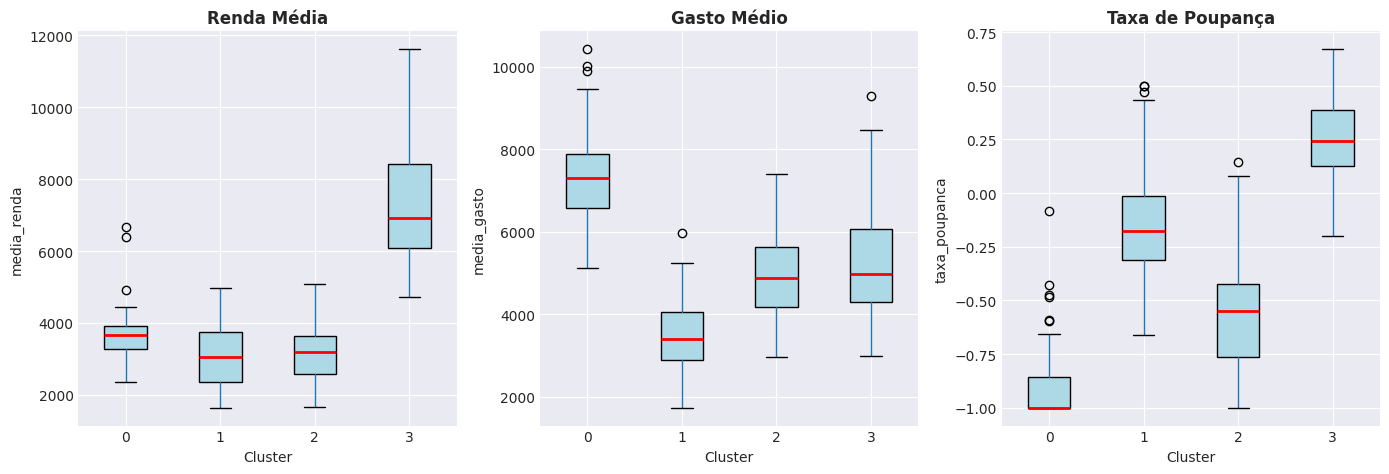

Salvo: ../outputs/boxplots_clusters.png


In [6]:
# 3 boxplots principais
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

features_plot = ['media_renda', 'media_gasto', 'taxa_poupanca']
titles = ['Renda Média', 'Gasto Médio', 'Taxa de Poupança']

for ax, feature, title in zip(axes, features_plot, titles):
    df.boxplot(column=feature, by='cluster', ax=ax,
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.set_title(title, fontweight='bold')
    plt.suptitle('')

plt.tight_layout()
plt.savefig('../outputs/boxplots_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print('Salvo: ../outputs/boxplots_clusters.png')

## 6. Gerar Entregável: Perfis_Clusters.md

In [7]:
# Gerar arquivo Markdown
md_content = """# Perfis dos Clusters - Economiza+ MVP

## Resumo

| Cluster | Nome | Usuários | % Base | Renda Média | Gasto Médio | Saldo | Taxa Poupança |
|---------|------|----------|--------|-------------|-------------|-------|---------------|
"""

# Adicionar linhas da tabela
for cluster_id in sorted(medias.index):
    nome = cluster_names[cluster_id]
    qtd = int(medias.loc[cluster_id, 'qtd_usuarios'])
    pct = medias.loc[cluster_id, 'pct_base']
    renda = medias.loc[cluster_id, 'media_renda']
    gasto = medias.loc[cluster_id, 'media_gasto']
    saldo = renda - gasto
    taxa = medias.loc[cluster_id, 'taxa_poupanca'] * 100
    
    md_content += f"| {cluster_id} | {nome} | {qtd} | {pct:.1f}% | R$ {renda:,.0f} | R$ {gasto:,.0f} | R$ {saldo:+,.0f} | {taxa:+.1f}% |\n"

md_content += """
## Descrição dos Perfis

"""

# Descrições por perfil
descricoes = {
    'Poupadores': 'Usuários com renda acima da média e boa capacidade de poupança. Potencial para produtos de investimento.',
    'Equilibrados': 'Usuários que conseguem manter gastos próximos à renda. Oportunidade para incentivar maior poupança.',
    'Em Alerta': 'Usuários com gastos levemente superiores à renda. Necessitam orientação para equilibrar finanças.',
    'Endividados': 'Usuários com gastos muito acima da renda. Prioridade para intervenção e educação financeira.'
}

for cluster_id in sorted(medias.index):
    nome = cluster_names[cluster_id]
    desc = descricoes.get(nome, '')
    qtd = int(medias.loc[cluster_id, 'qtd_usuarios'])
    taxa = medias.loc[cluster_id, 'taxa_poupanca'] * 100
    
    md_content += f"""### Cluster {cluster_id}: {nome}

- **Usuários:** {qtd}
- **Taxa de Poupança:** {taxa:+.1f}%
- **Perfil:** {desc}

"""

md_content += """## Visualização

![Boxplots](../outputs/boxplots_clusters.png)

---
*Gerado automaticamente pelo notebook 05_Interpretacao_Clusters.ipynb*
"""

# Salvar arquivo
with open('../outputs/Perfis_Clusters.md', 'w', encoding='utf-8') as f:
    f.write(md_content)

print('Entregável salvo: ../outputs/Perfis_Clusters.md')
print('\n' + '='*50)
print('PREVIEW DO ARQUIVO:')
print('='*50)
print(md_content)

Entregável salvo: ../outputs/Perfis_Clusters.md

PREVIEW DO ARQUIVO:
# Perfis dos Clusters - Economiza+ MVP

## Resumo

| Cluster | Nome | Usuários | % Base | Renda Média | Gasto Médio | Saldo | Taxa Poupança |
|---------|------|----------|--------|-------------|-------------|-------|---------------|
| 0 | Endividados | 59 | 11.8% | R$ 3,693 | R$ 7,298 | R$ -3,605 | -88.6% |
| 1 | Em Alerta | 196 | 39.2% | R$ 3,131 | R$ 3,469 | R$ -337 | -14.8% |
| 2 | Endividados | 167 | 33.4% | R$ 3,155 | R$ 4,900 | R$ -1,746 | -57.7% |
| 3 | Poupadores | 78 | 15.6% | R$ 7,194 | R$ 5,236 | R$ +1,958 | +25.4% |

## Descrição dos Perfis

### Cluster 0: Endividados

- **Usuários:** 59
- **Taxa de Poupança:** -88.6%
- **Perfil:** Usuários com gastos muito acima da renda. Prioridade para intervenção e educação financeira.

### Cluster 1: Em Alerta

- **Usuários:** 196
- **Taxa de Poupança:** -14.8%
- **Perfil:** Usuários com gastos levemente superiores à renda. Necessitam orientação para equilibrar finanç

## 7. Checklist Final

In [8]:
print('='*50)
print('CHECKLIST - INTERPRETAÇÃO DOS CLUSTERS')
print('='*50)
print('[x] Médias por cluster')
print('[x] Nomear clusters')
print('[x] Tabela comparativa')
print('[x] 3 boxplots')
print('[x] Entregável: Perfis_Clusters.md')
print('='*50)
print('\nArquivos gerados:')
print('  - outputs/Perfis_Clusters.md')
print('  - outputs/boxplots_clusters.png')
print('\nCONCLUÍDO!')

CHECKLIST - INTERPRETAÇÃO DOS CLUSTERS
[x] Médias por cluster
[x] Nomear clusters
[x] Tabela comparativa
[x] 3 boxplots
[x] Entregável: Perfis_Clusters.md

Arquivos gerados:
  - outputs/Perfis_Clusters.md
  - outputs/boxplots_clusters.png

CONCLUÍDO!
